In [37]:
import sys, os
sys.path.append('../')
import numpy as np
import matplotlib.pyplot as plt
from src import utils
from sklearn.linear_model import Lasso

# load data from processed csv
path_loc = '../datasets/processed/united_states.csv'
data, dates, columns = utils.read_csv(path_loc)
print("Data columns: ", columns)
print("Max Daily Deaths: ", data[:,2].max())

# with 7-day moving average
mva_data, mva_dates = utils.moving_average(data, dates, days=7)
train, test, train_dates, test_dates = utils.train_test_split(mva_data, mva_dates, test_days=7)

Data columns:  ['cases', 'hospitalizations', 'deaths']
Max Daily Deaths:  4475.0


In [38]:
c_train, h_train, d_train = train[:,0], train[:,1], train[:,2]
c_test, h_test, d_test = test[:,0], test[:,1], test[:,2] 
#max_h = max(h_train)
#max_d = max(d_train)
max_h = 1
max_d = 1
h_train = h_train/max_h
d_train = d_train/max_d


In [47]:
# rolling window on h_train, d_train -> (nsamps, 2*input_days) -> (nsamps, 2)
x = []
y = []

train_size = h_train.size
roll_window_size = 14
for i in range(train_size - roll_window_size):
    x.append(np.concatenate((h_train[i:(i+roll_window_size)],d_train[i:(i+roll_window_size)])))
    y.append(np.concatenate(([h_train[i+roll_window_size]],[d_train[i+roll_window_size]])))

X = np.stack(x)
Y = np.stack(y)


In [48]:
#train
clf = Lasso(alpha = 0.1, max_iter = 10000000)
clf.fit(X, Y)


Lasso(alpha=0.1, max_iter=10000000)

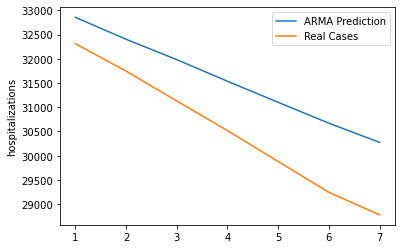

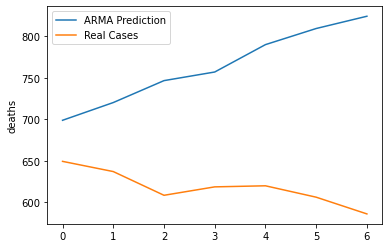

In [50]:
#make predictions
pred_horizon = h_test.size
pred = np.zeros((pred_horizon,2))
Z = X[[-1],:]

for i in range(pred_horizon):  
    pred[i,:] = clf.predict(Z)
    for j in range(2 * roll_window_size):
        if (j == roll_window_size - 1):  #28 = 2*14 where 14 is the moving-window length. Should make it L
            Z[0,j] = pred[i,0]
        elif (j == 2 * roll_window_size - 1):
            Z[0,j] = pred[i,1]
        else:
            Z[0,j] = Z[0,j+1]
    #print(pred)
    #print(Z)

#denormalize
pred[:,0] = max_h * pred[:,0]
pred[:,1] = max_d * pred[:,1]

#plot
plt.plot(np.arange(pred_horizon)+1, pred[:,0], label = 'ARMA Prediction')
plt.plot(np.arange(pred_horizon)+1, h_test, label = 'Real Cases')
plt.legend()
plt.ylabel('hospitalizations')
plt.show()

plt.plot(np.arange(pred_horizon), pred[:,1], label = 'ARMA Prediction')
plt.plot(np.arange(pred_horizon), d_test, label = 'Real Cases')
plt.legend()
plt.ylabel('deaths')
plt.show()


In [51]:
#Test rotation thing

w = np.arange(10)
print(w)
t = np.zeros((3,2))
t[0,:] = [11,22]
t[1,:] = [33,44]
t[2,:] = [55,66]
for i in range(3):
    print(i)
    for j in range(10):
        if (j == 4):
            w[j] = t[i,0]
        elif (j == 9):
            w[j] = t[i,1]
        else:
            w[j] = w[j+1]
    print(w)


[0 1 2 3 4 5 6 7 8 9]
0
[ 1  2  3  4 11  6  7  8  9 22]
1
[ 2  3  4 11 33  7  8  9 22 44]
2
[ 3  4 11 33 55  8  9 22 44 66]
